In [24]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model, Autoencoder, load_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, plot_histogram, visualize_train_val_error, selection_histograms, create_heatmap, cluster_and_visualize, \
                            get_gradarrays_n_labels, prep_tsne_min_max_ranges, sep_grads_by_labels, clean_final_analysis
#from GGH.imputation_methods import Imputer
import warnings
warnings.filterwarnings('ignore')

def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, dropout = 0.05, lr = 0.004, nu = 0.1,
                    normalize_grads_contx = False, use_context = True, final_analysis = False, use_auc_loss = False, use_confidence_weighting = False,
                    freqperc_cutoff = 0.25):
       
    AM = AlgoModulators(DO, lr = lr, nu = nu, normalize_grads_contx = False, use_context = True, freqperc_cutoff = freqperc_cutoff)
    dataloader = DO.prep_dataloader(use_info, batch_size)

    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout = dropout) 

    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, results_path, final_analysis = final_analysis)
    TVM.train_model(DO, AM, model, final_analysis = final_analysis)

    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = final_analysis)
    
    return DO, TVM, model

def multi_experiments(total_runs, use_info, num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                      INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters, final_analysis = True):
    
    clean_final_analysis(results_path, use_info)
    progress_bar = tqdm(total=total_runs)
    for r_state in range(2000): #
        set_to_deterministic(r_state)
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        DO.problem_type = 'regression'
        if not DO.lack_partial_coverage:
            full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                            dropout = hyperparameters["dropout"]["value"], lr = hyperparameters["lr"]["value"], nu = hyperparameters["nu"]["value"],
                            normalize_grads_contx = hyperparameters["normalize_grads_contx"]["value"], 
                            use_context = hyperparameters["use_context"]["value"], final_analysis = final_analysis,
                            use_confidence_weighting = hyperparameters["use_confidence_weighting"]["value"],
                            freqperc_cutoff = hyperparameters["freqperc_cutoff"]["value"])
            progress_bar.update(1)
        if progress_bar.n == total_runs:
            break       
    progress_bar.close()
    
def set_to_deterministic(rand_state):
    
    import random
    import numpy as np
    import torch
    
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)

    torch.set_num_threads(1)
    #torch.set_num_interop_threads(1)
    torch.use_deterministic_algorithms(True)

In [34]:
df = pd.read_csv('../data/wine/red_wine.csv')

<Axes: >

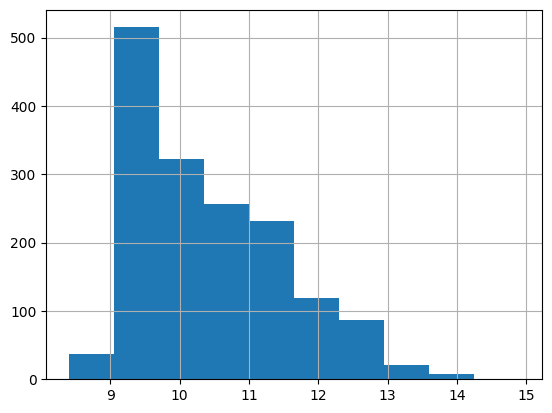

In [35]:
df.alcohol.hist()

<AxesSubplot:>

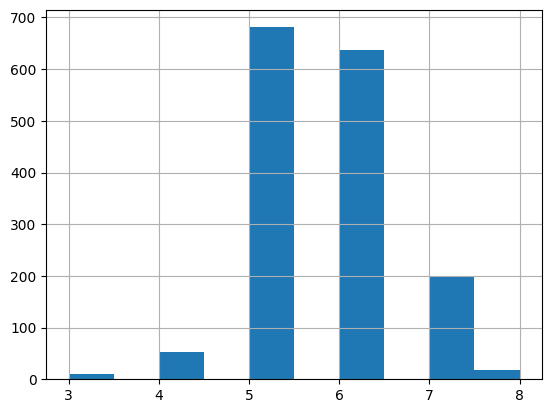

In [73]:
df.quality.hist()

In [22]:
#User requiered data and parameters
data_path = '../data/wine/red_wine.csv'
results_path = "../saved_results/Red Wine"
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid'] 
target_vars = ['quality']
miss_vars = ['alcohol']
hypothesis = [[9.35, 10, 11.5, 15]]

#Percentage of simulated data with full information
partial_perc = 0.015
rand_state = 42

#Model Train Parameters
hidden_size = 32

batch_size = 100*len(hypothesis[0])
output_size = len(target_vars)

#Call data, algorithm and model classes
INSPECT = Inspector(results_path, hidden_size)

In [25]:
use_info = "use hypothesis"
rand_state = 11
num_epochs = 20
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")

#though it's a multiclass type of target data, will treat it as regression
DO.problem_type = 'regression'

DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, final_analysis = False, freqperc_cutoff = 0.25)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))
best_model = load_model(DO, TVM.weights_save_path, batch_size)
print(INSPECT.calculate_val_r2score(DO, TVM, best_model, data="test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)


  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


0.18714517887126758
0.14686768928854232
0.213669400412698


findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.
findfont: Font family 'Cambria' not found.


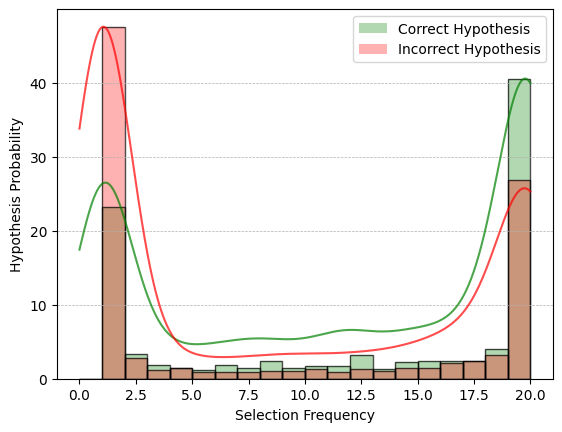

In [25]:
use_info = "use hypothesis"
rand_state = 11
num_epochs = 20
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")

#though it's a multiclass type of target data, will treat it as regression
DO.problem_type = 'regression'

DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))
best_model = load_model(DO, TVM.weights_save_path, batch_size)
print(INSPECT.calculate_val_r2score(DO, TVM, best_model, data="test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)


In [19]:
#Number of loops to ensure statistical significance
num_loops = 15
num_epochs = 50
epoch_amp = 4

partial_perc = 0.015

hyperparameters = {"lr": {"value": 0.002}, "dropout": {"value": 0.1}, "nu": {"value": 0.1} ,
                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
                   "use_confidence_weighting": {"value":False}, "freqperc_cutoff": {"value":0.25} }

In [20]:
#%%capture

#multi_experiments(num_loops, "use hypothesis", num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
#                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "partial info",   int(num_epochs*epoch_amp), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "use known only", int(num_epochs*epoch_amp), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
#multi_experiments(num_loops, "full info",      int(num_epochs*epoch_amp), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
#                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

Deleted 30 files in: ../saved_results/Red Wine/partial info/final_analysis



100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Deleted 30 files in: ../saved_results/Red Wine/use known only/final_analysis



100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


In [21]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.015

#hyperparameters = {"lr": {"value": 0.002}, "dropout": {"value": 0.1}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False}, "freqperc_cutoff": {"value":0.25} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
print(df_notavg[df_notavg["Method"]=="partial info"]["rand_states"].values)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

[list([0, 1, 5, 13, 19, 20, 25, 29, 32, 34, 35, 47, 49, 51, 53])]


,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.305458,0.017713,0.106368
1,partial info,0.198397,0.020345,0.114879
2,use hypothesis,0.200391,0.020370,0.114878
3,use known only,0.172335,0.021158,0.117498


In [18]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.015

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False}, "freqperc_cutoff": {"value":0.25} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
print(df_notavg[df_notavg["Method"]=="partial info"]["rand_states"].values)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

[list([0, 1, 5, 13, 19, 20, 25, 29, 32, 34, 35, 47, 49, 51, 53])]


,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.305458,0.017713,0.106368
1,partial info,0.173482,0.020952,0.116702
2,use hypothesis,0.200391,0.020370,0.114878
3,use known only,0.171489,0.021179,0.117642


In [7]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.015

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
print(df_notavg[df_notavg["Method"]=="partial info"]["rand_states"].values)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

[list([0, 1, 5, 13, 19, 20, 25, 29, 32, 34, 35, 47, 49, 51, 53])]


,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.305458,0.017713,0.106368
1,partial info,0.173482,0.020952,0.116702
2,use hypothesis,0.200391,0.020370,0.114878
3,use known only,0.171489,0.021179,0.117642


In [11]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.0125

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.292272,0.017569,0.105587
1,partial info,0.141693,0.021246,0.116501
2,use hypothesis,0.180186,0.020331,0.114257
3,use known only,0.173844,0.020541,0.116021


In [8]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.025

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.310787,0.018042,0.107467
1,partial info,0.191918,0.021159,0.117368
2,use hypothesis,0.222860,0.020375,0.115273
3,use known only,0.175430,0.021619,0.118883


In [42]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.01

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.287759,0.017484,0.105369
1,partial info,0.062254,0.022955,0.122091
2,use hypothesis,0.210357,0.021044,0.116355
3,use known only,0.163543,0.020553,0.116249


In [39]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.015

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.305458,0.017713,0.106368
1,partial info,0.173482,0.020952,0.116702
2,use hypothesis,0.210357,0.021044,0.116355
3,use known only,0.171489,0.021179,0.117642


In [36]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.02

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.310787,0.018042,0.107467
1,partial info,0.190641,0.021153,0.116296
2,use hypothesis,0.210357,0.021044,0.116355
3,use known only,0.175430,0.021619,0.118883


In [33]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.025

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.310787,0.018042,0.107467
1,partial info,0.191918,0.021159,0.117368
2,use hypothesis,0.210357,0.021044,0.116355
3,use known only,0.175430,0.021619,0.118883


In [30]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.035

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.321920,0.018055,0.106418
1,partial info,0.244982,0.020121,0.113255
2,use hypothesis,0.210357,0.021044,0.116355
3,use known only,0.177317,0.021936,0.119148


In [27]:
#num_loops = 15
#num_epochs = 50
#epoch_amp = 4
#partial_perc = 0.025

#hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
#                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
#                   "use_confidence_weighting": {"value":False} }

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")

print(df_notavg[df_notavg["Method"]=="partial info"]["rand_states"].values)

df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.302001,0.018277,0.108407
1,partial info,0.069822,0.024261,0.128240
2,use hypothesis,0.215543,0.020551,0.116059
3,use known only,0.164867,0.021909,0.119449


In [17]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.310787,0.018042,0.107467
1,partial info,0.191918,0.021159,0.117368
2,use known only,0.175430,0.021619,0.118883


In [18]:
df_notavg

,Method,rand_states,avg_r2_score,avg_mse,avg_mae,explained_variance
0,full info,"[0, 1, 5, 11, 13, 19, 20, 25, 29, 32, 34, 35, ...","[0.328715904466622, 0.3805894023662485, 0.2367...","[0.01616952651556582, 0.01733422170526485, 0.0...","[0.10505711048220594, 0.10515885629380743, 0.1...","[0.3449337024057708, 0.3812872518324001, 0.244..."
1,partial info,"[0, 1, 5, 11, 13, 19, 20, 25, 29, 32, 34, 35, ...","[0.1529737126587497, 0.27892583905305646, 0.20...","[0.02040270893303865, 0.020179279172073156, 0....","[0.11897621732205153, 0.11988212522119283, 0.1...","[0.17977515855796855, 0.2801490614040816, 0.20..."
2,use known only,"[0, 1, 5, 11, 13, 19, 20, 25, 29, 32, 34, 35, ...","[0.20186501347109465, 0.2316061122937444, 0.15...","[0.019225041846739552, 0.021503522957717056, 0...","[0.11701648791010182, 0.11963105611503123, 0.1...","[0.20397164231126752, 0.23668276740466998, 0.1..."


In [20]:
df_notavg[df_notavg["Method"]=="partial info"]["avg_r2_score"].values

array([list([0.1529737126587497, 0.27892583905305646, 0.2041922618126094, 0.16619055034589414, 0.14874601709719826, 0.19217811141740815, 0.26560759775645926, 0.3050336244354409, 0.11283129985087437, 0.11898746536485649, 0.1609183350027007, 0.23021122345123168, 0.24170211834870747, 0.0917315756961753, 0.20853623450324799])],
      dtype=object)

In [5]:
%%capture

for imput_method in ["Iterative MICE Imputer", "KNN Imputer", "Miss Forest", "Deep Regressor", "Soft Impute", 
                     "Matrix Factorization", "Hyperimpute", "TabPFN"]: #, "Midas"
    counter = 0
    use_info = "use imputation" 
    num_epochs = 400
    for r_state in range(300):
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            counter += 1
            AM = AlgoModulators(DO, lr = 0.004)
            IMP = Imputer(DO)
            dataloader = IMP.impute_w_sel(DO, imput_method, batch_size)

            model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
            TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path,
                                        imput_method = imput_method, final_analysis = True)
            TVM.train_model(DO, AM, model, final_analysis = True)
            INSPECT.save_train_val_logs(DO, AM, TVM, model, imput_method, final_analysis = True)
        if counter == 15:
            break
            

In [6]:
#partial 8%
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Deep Regressor,0.021994,0.006158
1,Hyperimpute,0.014798,0.003372
2,Iterative MICE Imputer,0.017025,0.002185
3,KNN Imputer,0.015783,0.002854
4,Matrix Factorization,0.028538,0.002555
5,Miss Forest,0.013798,0.003545
6,Soft Impute,0.028846,0.002594
7,TabPFN,0.010166,0.002840


In [7]:
#partial 8%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "TabPFN") #
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.828043,0.005827,0.056247
1,partial info,0.528283,0.015641,0.095204
2,use hypothesis,0.742764,0.008592,0.071962
3,use imputation,0.737578,0.008739,0.068960
4,use known only,0.623568,0.012632,0.088167
